### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 25 ноября 2019, 15:00   
**Штраф за опоздание:** -2 балла после 15:00 25 ноября, -4 балла после 15:00 2 декабря, -6 баллов после 15:00 9 декабря  -8 баллов после 15:00 16 декабря.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0919, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

###### Задание 1 (3 балла)
Разберитесь в коде MyDecisionTreeClassifier, который уже частично реализован. Допишите код там, где написано "Ваш код". Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn. Точность проверяется на [wine](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html) и [Speed Dating Data](https://cloud.mail.ru/public/8nHV/p6J7wY1y1)

###### Задание 2 (3 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine и Speed Dating Data. 
Для этого используем numpy.

###### Задание 3 (2 балла)
Добавьте функционал, который определяет значения feature importance. Выведите 10 главных фичей под пунктом Задание 4 (уже написано ниже) для MyDecisionTreeClassifier и DecisionTreeClassifier так, чтобы сразу были видны выводы и по MyDecisionTreeClassifier, и по DecisionTreeClassifier. Используем данные Speed Dating Data.

###### Задание 4 (2 балла)
С помощью GridSearchCV или RandomSearchCV подберите наиболее оптимальные параметры для случайного леса (Выберете 2-3 параметра). Используем данные Speed Dating Data. Задание реализуйте под пунктом Задание 5 (уже написано ниже)


**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw3.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

%matplotlib inline
%load_ext pycodestyle_magic
from collections import Counter

In [2]:
#%%pycodestyle


class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=None,\
                 sufficient_share=1.0, criterion='gini',  max_features=None):
        self.tree = dict()
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.sufficient_share = sufficient_share
        self.num_class = -1
        self.feature_importances_ = None
        if criterion == 'gini':
            self.G_function = self.__gini
        elif criterion == 'entropy':
            self.G_function = self.__entropy
        elif criterion == 'misclass':
            self.G_function = self.__misclass
        else:
            print('invalid criterion name')
            raise

        if max_features == 'sqrt':
            self.get_feature_ids = self.__get_feature_ids_sqrt
        elif max_features == 'log2':
            self.get_feature_ids = self.__get_feature_ids_log2
        elif max_features == None:
            self.get_feature_ids = self.__get_feature_ids_N
        else:
            print('invalid max_features name')
            raise

    def __gini(self, l_c, l_s, r_c, r_s):
        l_s = l_s.astype('float')
        r_s = r_s.astype('float')
        return 1 - (l_c**2 / l_s + r_c**2 / r_s).sum(axis=1)   # Ваш код в 1 строчку


    def __entropy(self, l_c, l_s, r_c, r_s):
        return -(l_c * np.log(l_c) / l_s + r_c * np.log(r_c) / r_s).sum(axis=1)  # Ваш код в 1 строчку

    def __misclass(self, l_c, l_s, r_c, r_s):
        return 1 - (l_c.max(axis=1) + r_c.max(axis=1)) / (l_s[0] + r_s[0]) # Ваш код в 1 строчку

    def __get_feature_ids_sqrt(self, n_feature):
        feature_ids = range(n_feature)
        np.random.shuffle(feature_ids)
        return feature_ids[:round(np.sqrt(n_feature))]  # Ваш код в 1 строчку

    def __get_feature_ids_log2(self, n_feature):
        feature_ids = range(n_feature)
        np.random.shuffle(feature_ids)
        return feature_ids[:round(np.log2(n_feature))]  # Ваш код в 1 строчку

    def __get_feature_ids_N(self, n_feature):
        return range(n_feature)  # Ваш код

    def __sort_samples(self, x, y):
        sorted_idx = x.argsort()
        return x[sorted_idx], y[sorted_idx]

    def __div_samples(self, x, y, feature_id, threshold):
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        # Ваш код
        
        x_sort, y_sort = self.__sort_samples(x, y)
        num_class = self.num_class
        cut_size = np.int(self.min_samples_split / 2 - 1)
        
        if cut_size == 0:
            splitted_y_sort = y_sort
        else:
            splitted_y_sort = y_sort[cut_size:-cut_size]
        r_bord = np.where(splitted_y_sort[:-1] != splitted_y_sort[1:]
                                )[0] + (cut_size + 1)

        if len(r_bord) == 0:
            return np.inf, None
        
        eq_el_count = r_bord - np.append(np.array([cut_size]), r_bord[:-1])
        one_hot_code = np.zeros((r_bord.shape[0], num_class))
        one_hot_code[np.arange(r_bord.shape[0]), y_sort[r_bord- 1]] = 1
        class_increments = one_hot_code * eq_el_count.reshape(-1, 1)
        class_increments[0] = class_increments[0] + \
                np.bincount(y_sort[:cut_size], minlength=num_class)

        l_c = np.cumsum(class_increments, axis=0)
        r_c = np.bincount(y_sort, minlength=num_class) - l_c
        l_s = r_bord.reshape(l_c.shape[0], 1)
        r_s = y_sort.shape[0] - l_s

        g_func = self.G_function(l_c, l_s, r_c, r_s)
        idx = np.argmin(g_func)

        left_el_id = l_s[idx][0]
        return g_func[idx], (x_sort[left_el_id - 1] + x_sort[left_el_id]) / 2.0
        #pass
    
    def __fit_node(self, x, y, node_id, depth, pred_f=-1):
        # Ваш код
        
        if (self.max_depth is not None) and (depth > self.max_depth) or\
                y.shape[0] <= self.min_samples_split or\
                ((np.bincount(y).max() / y.shape[0]) >= self.sufficient_share):

            buf = np.bincount(y)
            self.tree[node_id] = (self.__class__.LEAF_TYPE, buf.argmax(),
                                  buf.astype(float) / y.size)
            return

        ids = self.get_feature_ids(x.shape[1])
        trs = np.array([self.__find_threshold(x[:, idx], y) for idx in ids])

        best_trs_idx = trs[:, 0].argmin()
        best_trs_val = trs[best_trs_idx, 1]

        l_x, r_x, l_y, r_y = self.__div_samples(x, y, ids[best_trs_idx],
                                                best_trs_val)

        if l_x.shape[0] == 0 or r_x.shape[0] == 0:
            buf = np.bincount(y)
            self.tree[node_id] = (self.__class__.LEAF_TYPE, buf.argmax(),
                                  buf.astype(float) / y.size)
            return

        self.tree[node_id] = (self.__class__.NON_LEAF_TYPE, ids[best_trs_idx],
                              best_trs_val)

        self.__fit_node(l_x, l_y, node_id * 2 + 1, depth + 1)
        self.__fit_node(r_x, r_y, node_id * 2 + 2, depth + 1)

        self.feature_importances_[best_trs_idx] += 1 / (depth**2 + 1)
        #pass

    def fit(self, x, y):
        self.num_class = np.unique(y).size
        self.feature_importances_ = np.zeros(x.shape[1])
        self.__fit_node(x, y, 0, 0)
        self.feature_importances_ = \
            self.feature_importances_ / np.sum(self.feature_importances_)

    def __predict_class(self, x, node_id):
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]

    def __predict_probs(self, x, node_id):
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_probs(x, 2 * node_id + 1)
            else:
                return self.__predict_probs(x, 2 * node_id + 2)
        else:
            return node[2]

    def predict(self, X):
        return np.array([self.__predict_class(x, 0) for x in X])

    def predict_probs(self, X):
        return np.array([self.__predict_probs(x, 0) for x in X])

    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)

In [3]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [4]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

## Проверка скорости работы на wine

In [5]:
%time clf.fit(X_train, y_train)

CPU times: user 1.42 ms, sys: 748 µs, total: 2.16 ms
Wall time: 1.46 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [6]:
%time my_clf.fit(X_train, y_train)

CPU times: user 14 ms, sys: 2.1 ms, total: 16.1 ms
Wall time: 15.6 ms


## Проверка качества работы на wine

In [7]:
f1_score(y_pred=clf.predict(X_test), y_true=y_test, average='macro')

0.890993265993266

In [8]:
f1_score(y_pred=my_clf.predict(X_test), y_true=y_test, average='macro')

0.9474747474747475

## Подготовка данных Speed Dating Data 

In [9]:
speed_dating_data = pd.read_csv('data/speed-dating-experiment/SpeedDatingData.csv', encoding='cp1251')
speed_dating_data



,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,552,22.0,1,44,2,21,22,14,10.0,5,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0
8374,552,22.0,1,44,2,21,22,13,10.0,4,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0
8375,552,22.0,1,44,2,21,22,19,10.0,10,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0
8376,552,22.0,1,44,2,21,22,3,10.0,16,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0


In [10]:
speed_dating_data.drop('positin1', axis = 1, inplace=True)
speed_dating_data.drop('iid', axis = 1, inplace=True)
speed_dating_data.drop('id', axis = 1, inplace=True)
speed_dating_data.drop('position', axis = 1, inplace=True)
speed_dating_data.drop('partner', axis = 1, inplace=True)
speed_dating_data.drop('pid', axis = 1, inplace=True)
speed_dating_data.drop(['pf_o_att', 'pf_o_int', 'pf_o_amb', 'pf_o_sin', 'pf_o_fun', 'pf_o_sha', 'field', 'from', 'zipcode', 'tuition', 'undergra'], axis = 1, inplace=True)
speed_dating_data.drop(['idg','condtn','wave','round','order'], axis = 1, inplace = True)
speed_dating_data.loc[:, 'income'] = speed_dating_data.loc[:, 'income'].str.replace(',', '').astype(np.float)
speed_dating_data.loc[:, 'income'] = speed_dating_data.loc[:, 'income'].fillna(-1)
speed_dating_data.loc[:, 'mn_sat'] = speed_dating_data.loc[:, 'mn_sat'].str.replace(',', '').astype(np.float)
speed_dating_data.loc[:, 'mn_sat'] = speed_dating_data.mn_sat.fillna(0)
speed_dating_data.drop(['imprace', 'imprelig', 'career', 'sports', 'tvsports', 'dining', 'museums', 'art',\
                       'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', \
                        'shopping', 'yoga', 'exphappy', 'goal'], axis = 1, inplace=True)
speed_dating_data = speed_dating_data.fillna(-1)

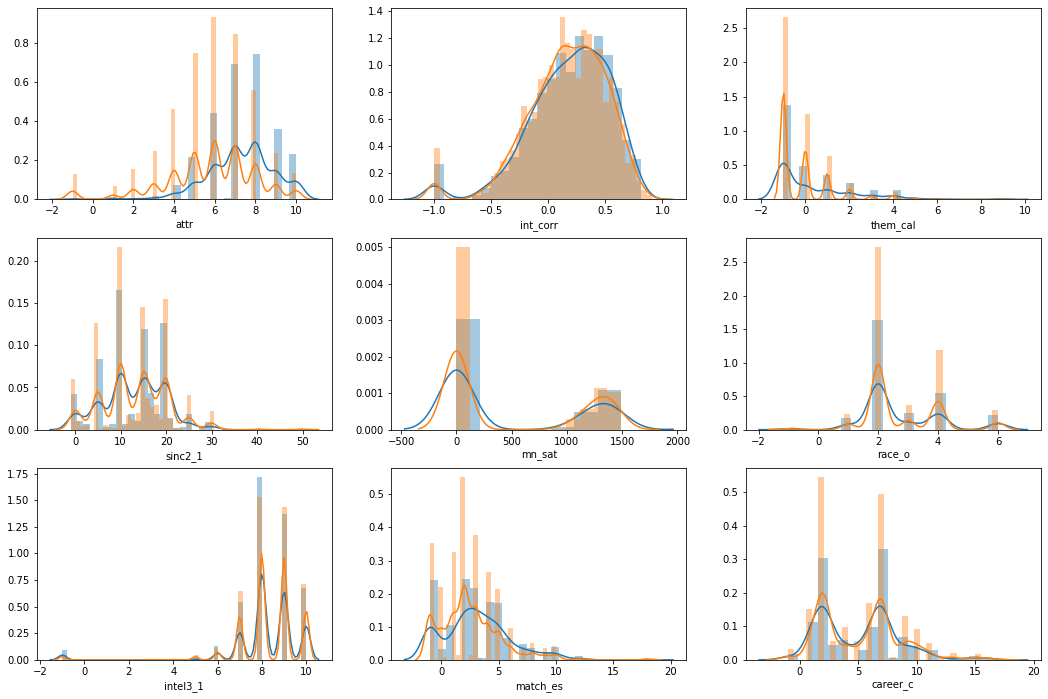

In [11]:
feature_match = speed_dating_data[speed_dating_data['match'] ==1].attr
feature_not_match = speed_dating_data[speed_dating_data['match'] ==0].attr
features = ['attr', 'int_corr', 'them_cal', 'sinc2_1', 'mn_sat',  'race_o', 'intel3_1', 'match_es', 'career_c']
plt.figure(figsize=(18,12))
for i, feat in enumerate(features):
    feature_match = speed_dating_data[speed_dating_data['match'] ==1][feat]
    feature_not_match = speed_dating_data[speed_dating_data['match'] ==0][feat]
    plt.subplot(3, 3, i+1)
    sns.distplot(feature_match)
    sns.distplot(feature_not_match)
    

In [12]:
X = speed_dating_data[['int_corr','age_o','race_o','attr_o', 'sinc_o', 'intel_o','fun_o', 'amb_o','shar_o',\
                       'like_o','prob_o', 'met_o','age', 'attr', 'sinc', 'intel', 'fun', 'income', 'mn_sat',\
                       'amb', 'shar', 'like', 'prob', 'met', 'match_es', 'income', 'date', 'you_call', 'them_cal', 'dec']]
y = speed_dating_data['match']
cols = X.columns
X_asnp = np.array(X)
y_asnp = np.array(y)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_asnp, y_asnp, test_size=0.1)

## Проверка скорости работы на Speed Dating Data 

In [14]:
clf = DecisionTreeClassifier(min_samples_split=2)
%time clf.fit(X_train, y_train)


CPU times: user 33.6 ms, sys: 2.17 ms, total: 35.8 ms
Wall time: 35.5 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [15]:
myclf = MyDecisionTreeClassifier(min_samples_split=2)
%time myclf.fit(X_train, y_train)


CPU times: user 482 ms, sys: 4.97 ms, total: 487 ms
Wall time: 488 ms


## Проверка качества работы на Speed Dating Data

In [16]:
print(f1_score(y_pred=clf.predict(X_test), y_true=y_test, average='macro'))

0.7757536460102303


In [17]:
print(f1_score(myclf.predict(X_test), y_test, average='macro'))

0.8241812737225582


## Задание 3

## Задание 4

In [18]:
ids = (-clf.feature_importances_).argsort()[:10]

for i in ids:
    print(cols[i], '\t', clf.feature_importances_[i])

dec 	 0.27227826208081346
like_o 	 0.18653004712154964
attr_o 	 0.07642848792450987
prob_o 	 0.03301112812711764
prob 	 0.03213169665569455
like 	 0.02627526771183343
int_corr 	 0.025598533778693935
shar_o 	 0.024437002037032418
fun_o 	 0.021881705021222303
match_es 	 0.020708175692594935


In [19]:
ids = (-myclf.feature_importances_).argsort()[:10]

for i in ids:
    print(cols[i], '\t', myclf.feature_importances_[i])

dec 	 0.21241247933527316
like_o 	 0.15243719105237252
attr_o 	 0.10879663575709114
prob_o 	 0.05732562702279487
fun_o 	 0.05455041576919004
race_o 	 0.03682869329398921
age_o 	 0.03588094421954544
int_corr 	 0.032419765300239885
shar_o 	 0.03170664198173654
prob 	 0.02923795303791407


## Задание 5

In [20]:
import time
clf = RandomForestClassifier(n_estimators=20)
param_grid = {  'n_estimators':[5,10, 20, 50],
                'min_samples_split':[2, 5, 10],
                'max_depth':[5, 10, 50, 100],
                 'criterion':['gini', 'entropy'],
                 'max_features': [None, 5, 10, 20]}
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=3, iid=False, scoring='f1_macro', n_jobs = 5)

grid_search.fit(X_asnp, y_asnp)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=20, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid=Fal

In [21]:
grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 10,
 'min_samples_split': 2,
 'n_estimators': 50}

In [22]:
grid_search.best_score_

0.8244947820625397